# Time series - TensorFlow

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['New_cases', 'Deaths']]

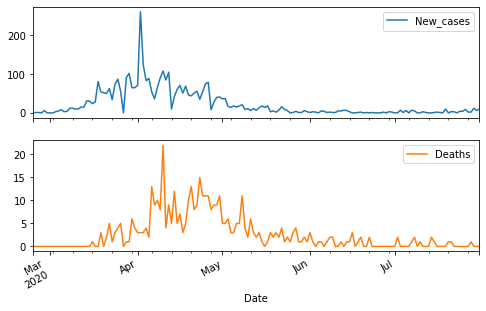

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


In [11]:
# Make it stationary, remove trend and seasonality
res = np.log(df[compart]) - np.log(df[compart]).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')

res_fix.dropna(inplace=True)

decomposed = seasonal_decompose(res_fix,model='additive',extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

In [12]:
adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -10.083327962059796
p-value: 1.1728864852470525e-17
Critial Values:
   1%, -3.4729792729247793
Critial Values:
   5%, -2.8802520918255534
Critial Values:
   10%, -2.5767469641683105

KPSS Statistic: 0.093547
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


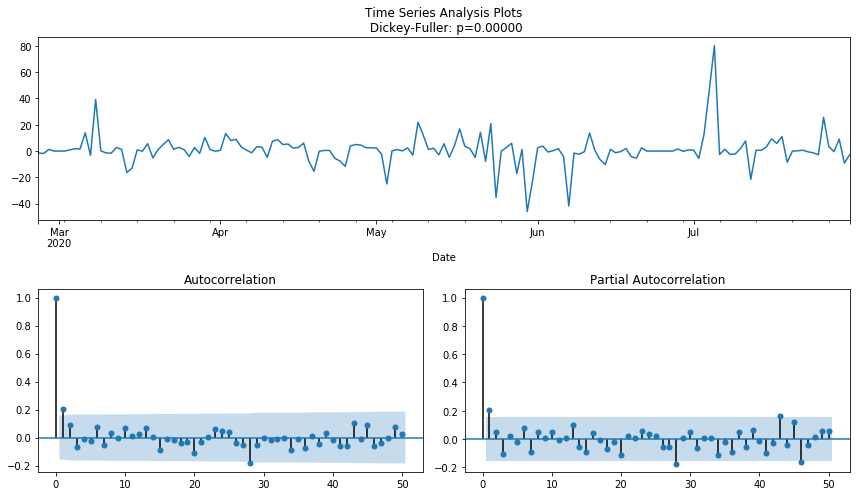

In [13]:
tsplot(deseasonalized, lags=50)

In [14]:
df_temp = pd.DataFrame(deseasonalized, columns=[compart])

In [15]:
# Make it stationary, remove trend and seasonality
res = np.log(df['Deaths']) - np.log(df['Deaths']).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')

res_fix.dropna(inplace=True)

decomposed = seasonal_decompose(res_fix,model='additive',extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -5.4905331570359905
p-value: 2.180401202216383e-06
Critial Values:
   1%, -3.4870216863700767
Critial Values:
   5%, -2.8863625166643136
Critial Values:
   10%, -2.580009026141913

KPSS Statistic: 0.061227
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


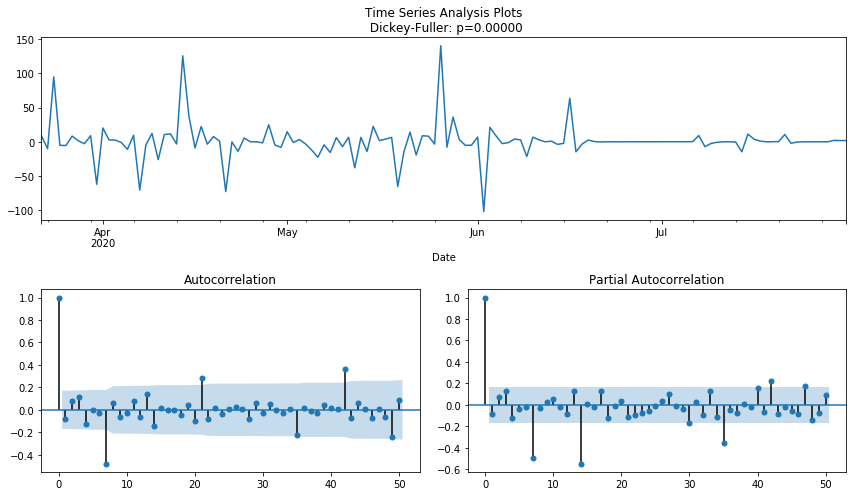

In [16]:
tsplot(deseasonalized, lags=50)

In [17]:
df_temp['Deaths'] = deseasonalized
df = df_temp.copy()

In [18]:
df.fillna(0, inplace=True)

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [22]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [23]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 3.1525 - mean_absolute_error: 0.8639 - mean_squared_error: 3.1525


In [24]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [25]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

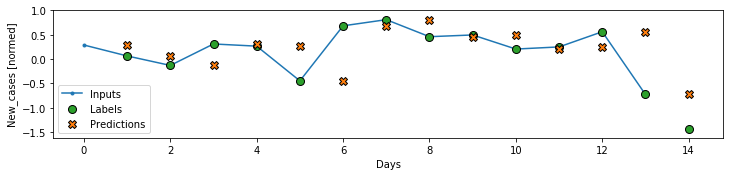

In [26]:
wide_window.plot(baseline)

In [27]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [28]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 41ms/step - loss: 2.1763 - mean_absolute_error: 1.0015 - mean_squared_error: 2.1763 - val_loss: 3.1633 - val_mean_absolute_error: 0.9323 - val_mean_squared_error: 3.1633
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 2.1647 - mean_absolute_error: 0.9984 - mean_squared_error: 2.1647 - val_loss: 3.1519 - val_mean_absolute_error: 0.9309 - val_mean_squared_error: 3.1519
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 2.1539 - mean_absolute_error: 0.9956 - mean_squared_error: 2.1539 - val_loss: 3.1404 - val_mean_absolute_error: 0.9297 - val_mean_squared_error: 3.1404
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 2.1424 - mean_absolute_error: 0.9928 - mean_squared_error: 2.1424 - val_loss: 3.1293 - val_mean_absolute_error: 0.9286 - val_mean_squared_error: 3.1293
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 2.1305 - mean_absolute_error: 0.9898 

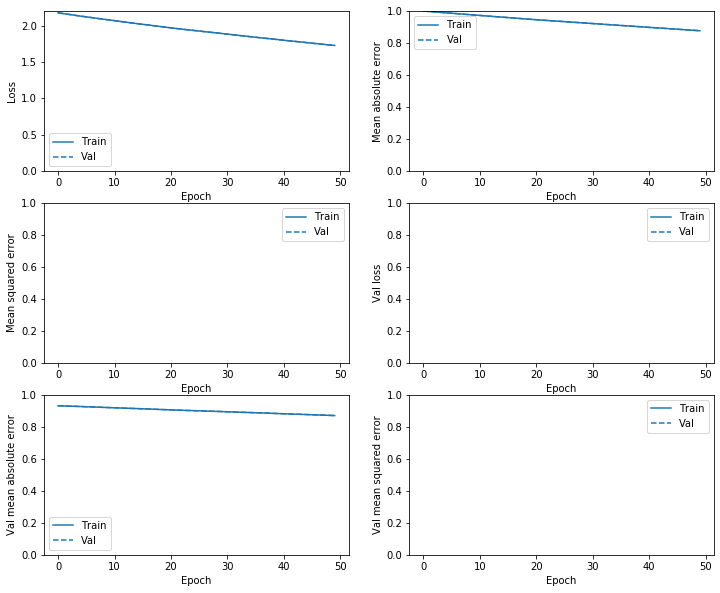

In [29]:
plot_metrics(history)

In [30]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.6894 - mean_absolute_error: 0.8709 - mean_squared_error: 2.6894


In [31]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

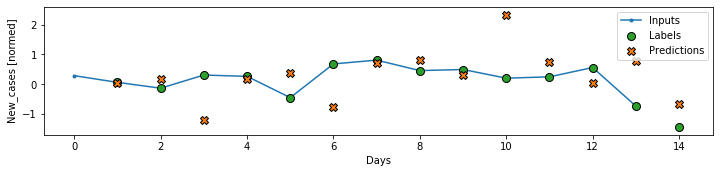

In [32]:
wide_window.plot(linear)

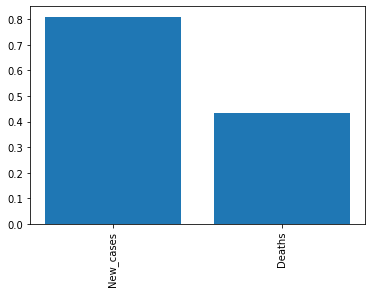

In [33]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 54ms/step - loss: 1.0271 - mean_absolute_error: 0.6018 - mean_squared_error: 1.0271 - val_loss: 2.7493 - val_mean_absolute_error: 0.6400 - val_mean_squared_error: 2.7493
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.9965 - mean_absolute_error: 0.5854 - mean_squared_error: 0.9965 - val_loss: 2.6712 - val_mean_absolute_error: 0.6421 - val_mean_squared_error: 2.6712
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 0.9834 - mean_absolute_error: 0.5839 - mean_squared_error: 0.9834 - val_loss: 2.6274 - val_mean_absolute_error: 0.6511 - val_mean_squared_error: 2.6274
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.9720 - mean_absolute_error: 0.5831 - mean_squared_error: 0.9720 - val_loss: 2.6529 - val_mean_absolute_error: 0.6533 - val_mean_squared_error: 2.6529
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 0.9658 - mean_absolute_error: 0.5845 

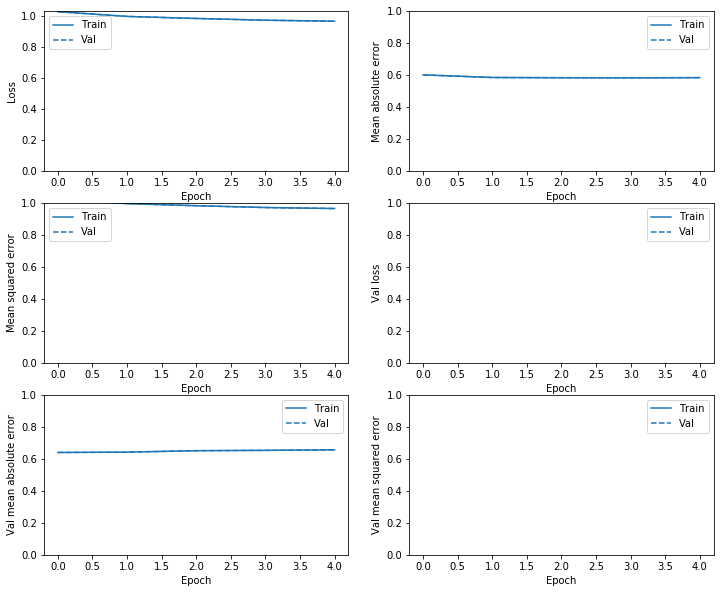

In [35]:
plot_metrics(history)

In [36]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.6711 - mean_absolute_error: 0.6567 - mean_squared_error: 2.6711


In [37]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [38]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

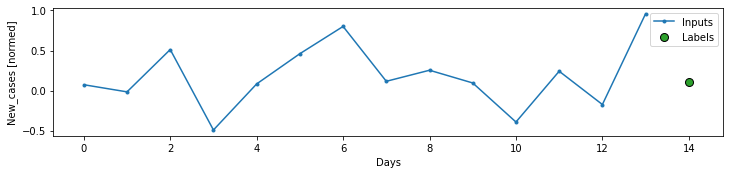

In [39]:
conv_window.plot()

In [40]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [41]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
3/3 [==============================] - 0s 73ms/step - loss: 1.7019 - mean_absolute_error: 0.8689 - mean_squared_error: 1.7019 - val_loss: 5.5173 - val_mean_absolute_error: 1.4765 - val_mean_squared_error: 5.5173
Epoch 2/50
3/3 [==============================] - 0s 27ms/step - loss: 1.4833 - mean_absolute_error: 0.8009 - mean_squared_error: 1.4833 - val_loss: 5.3291 - val_mean_absolute_error: 1.4237 - val_mean_squared_error: 5.3291
Epoch 3/50
3/3 [==============================] - 0s 26ms/step - loss: 1.3369 - mean_absolute_error: 0.7528 - mean_squared_error: 1.3369 - val_loss: 5.1926 - val_mean_absolute_error: 1.3821 - val_mean_squared_error: 5.1926
Epoch 4/50
3/3 [==============================] - 0s 25ms/step - loss: 1.2415 - mean_absolute_error: 0.7209 - mean_squared_error: 1.2415 - val_loss: 5.0918 - val_mean_absolute_error: 1.3464 - val_mean_squared_error: 5.0918
Epoch 5/50
3/3 [==============================] - 0s 26ms/step - loss: 1.1416 - mean_absolute_error: 0.6849 

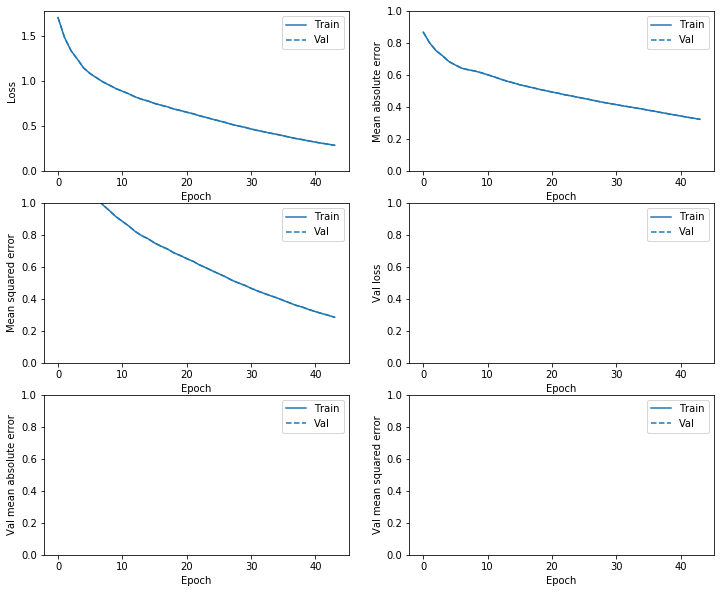

In [42]:
plot_metrics(history)

In [43]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 4.5425 - mean_absolute_error: 1.3048 - mean_squared_error: 4.5425


In [44]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

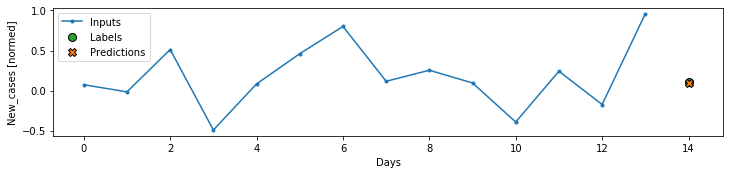

In [45]:
conv_window.plot(multi_step_dense)

In [46]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [47]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 1s 187ms/step - loss: 1.0070 - mean_absolute_error: 0.6090 - mean_squared_error: 1.0070 - val_loss: 3.5439 - val_mean_absolute_error: 0.7505 - val_mean_squared_error: 3.5439
Epoch 2/50
3/3 [==============================] - 0s 30ms/step - loss: 0.9953 - mean_absolute_error: 0.6048 - mean_squared_error: 0.9953 - val_loss: 3.5236 - val_mean_absolute_error: 0.7499 - val_mean_squared_error: 3.5236
Epoch 3/50
3/3 [==============================] - 0s 28ms/step - loss: 0.9863 - mean_absolute_error: 0.6021 - mean_squared_error: 0.9863 - val_loss: 3.5109 - val_mean_absolute_error: 0.7491 - val_mean_squared_error: 3.5109
Epoch 4/50
3/3 [==============================] - 0s 31ms/step - loss: 0.9760 - mean_absolute_error: 0.6007 - mean_squared_error: 0.9760 - val_loss: 3.4944 - val_mean_absolute_error: 0.7488 - val_mean_squared_error: 3.4944
Epoch 5/50
3/3 [==============================] - 0s 26ms/step - loss: 0.9691 - mean_absolute_error: 0.5997

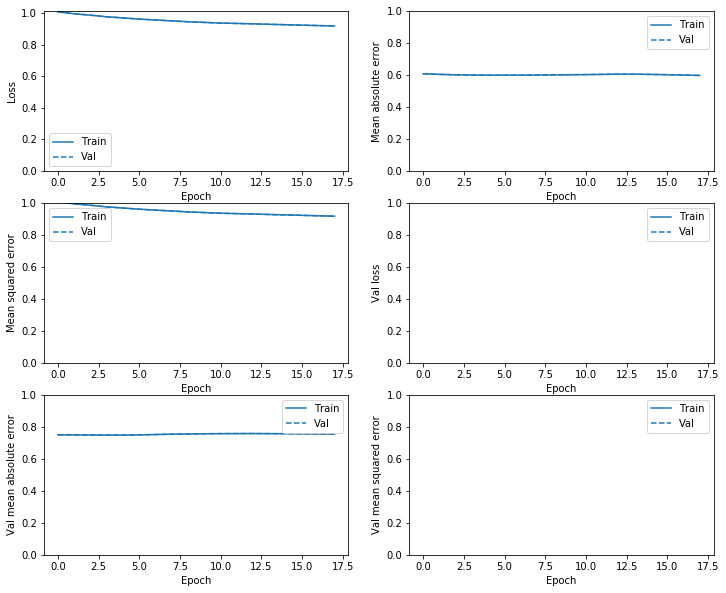

In [48]:
plot_metrics(history)

In [49]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 877us/step - loss: 3.4298 - mean_absolute_error: 0.7557 - mean_squared_error: 3.4298


In [50]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

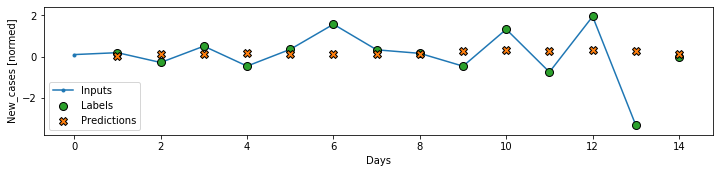

In [51]:
wide_window.plot(lstm_model)

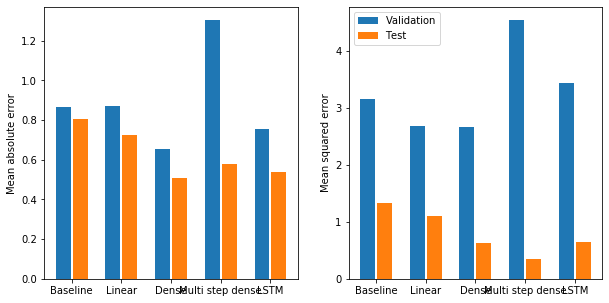

In [52]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [53]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [54]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [55]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 801us/step - loss: 1.9152 - mean_absolute_error: 0.5080 - mean_squared_error: 1.9152


In [56]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

In [57]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [58]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 44ms/step - loss: 1.0510 - mean_absolute_error: 0.5686 - mean_squared_error: 1.0510 - val_loss: 1.3637 - val_mean_absolute_error: 0.4184 - val_mean_squared_error: 1.3637
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 1.0100 - mean_absolute_error: 0.5405 - mean_squared_error: 1.0100 - val_loss: 1.3771 - val_mean_absolute_error: 0.4126 - val_mean_squared_error: 1.3771
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.9899 - mean_absolute_error: 0.5283 - mean_squared_error: 0.9899 - val_loss: 1.3945 - val_mean_absolute_error: 0.4178 - val_mean_squared_error: 1.3945


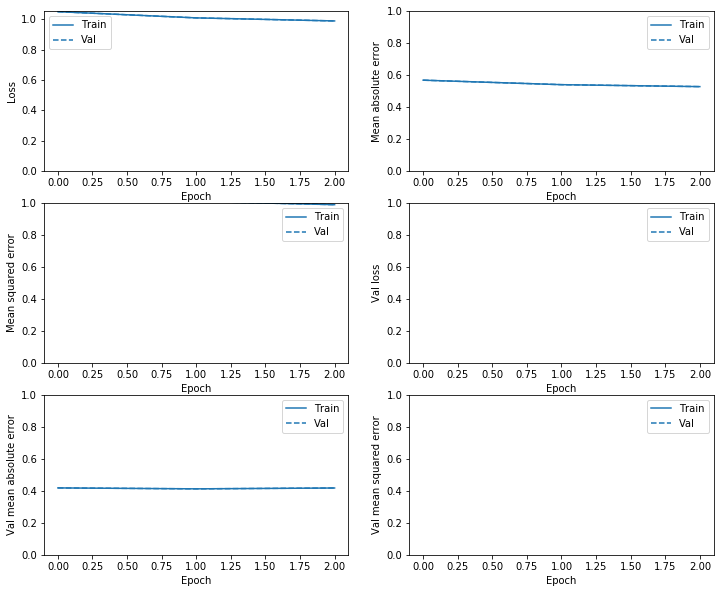

In [59]:
plot_metrics(history)

In [60]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 861us/step - loss: 1.3945 - mean_absolute_error: 0.4178 - mean_squared_error: 1.3945


In [61]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [62]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 1.0409 - mean_absolute_error: 0.5741 - mean_squared_error: 1.0409 - val_loss: 1.7052 - val_mean_absolute_error: 0.4454 - val_mean_squared_error: 1.7052
Epoch 2/50
3/3 [==============================] - 0s 28ms/step - loss: 1.0363 - mean_absolute_error: 0.5733 - mean_squared_error: 1.0363 - val_loss: 1.7054 - val_mean_absolute_error: 0.4412 - val_mean_squared_error: 1.7054
Epoch 3/50
3/3 [==============================] - 0s 26ms/step - loss: 1.0321 - mean_absolute_error: 0.5721 - mean_squared_error: 1.0321 - val_loss: 1.7042 - val_mean_absolute_error: 0.4371 - val_mean_squared_error: 1.7042
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 1.0284 - mean_absolute_error: 0.5709 - mean_squared_error: 1.0284 - val_loss: 1.7040 - val_mean_absolute_error: 0.4348 - val_mean_squared_error: 1.7040
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0246 - mean_absolute_error: 0.5700

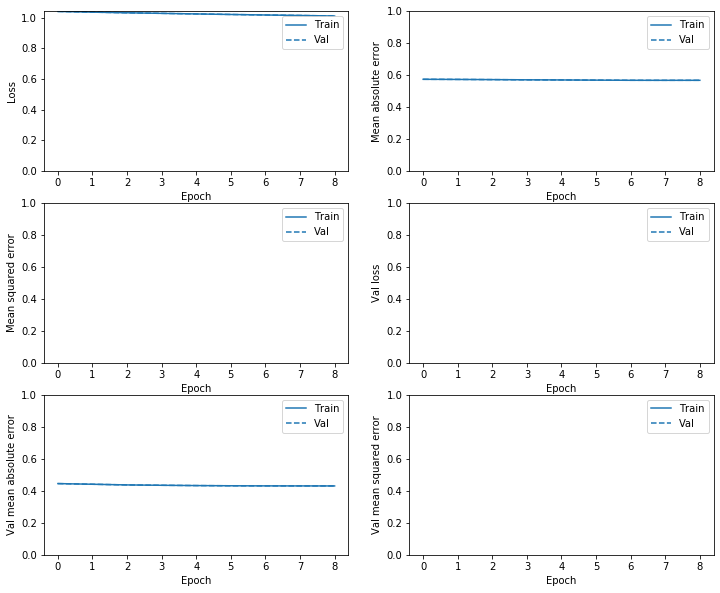

In [63]:
plot_metrics(history)

In [64]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 957us/step - loss: 1.7017 - mean_absolute_error: 0.4307 - mean_squared_error: 1.7017


In [65]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [66]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
3/3 [==============================] - 0s 128ms/step - loss: 2.0970 - mean_absolute_error: 0.8944 - mean_squared_error: 2.0970 - val_loss: 1.9095 - val_mean_absolute_error: 0.5090 - val_mean_squared_error: 1.9095
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 2.0918 - mean_absolute_error: 0.8931 - mean_squared_error: 2.0918 - val_loss: 1.9036 - val_mean_absolute_error: 0.5094 - val_mean_squared_error: 1.9036
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 2.0863 - mean_absolute_error: 0.8917 - mean_squared_error: 2.0863 - val_loss: 1.8978 - val_mean_absolute_error: 0.5098 - val_mean_squared_error: 1.8978
Epoch 4/50
3/3 [==============================] - 0s 26ms/step - loss: 2.0806 - mean_absolute_error: 0.8903 - mean_squared_error: 2.0806 - val_loss: 1.8918 - val_mean_absolute_error: 0.5102 - val_mean_squared_error: 1.8918
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 2.0740 - mean_absolute_error: 0.8888

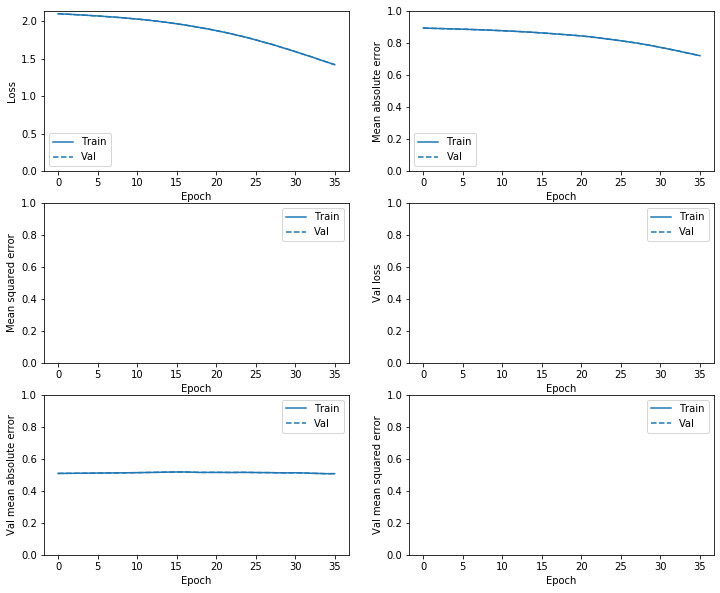

In [67]:
plot_metrics(history)

In [68]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 1.6806 - mean_absolute_error: 0.5076 - mean_squared_error: 1.6806


In [69]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

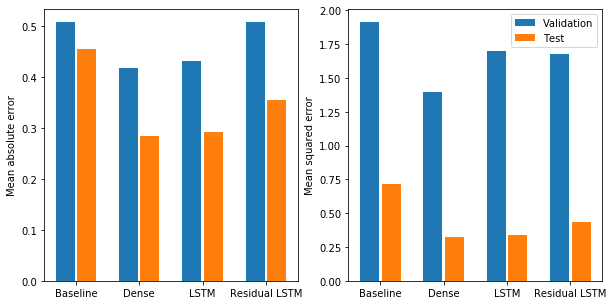

In [70]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

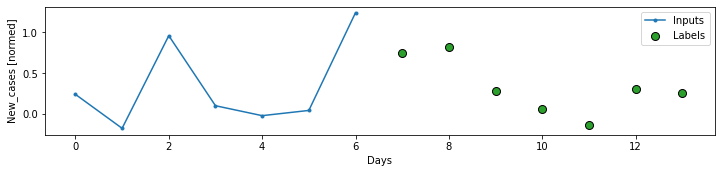

In [71]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot()

In [72]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [73]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

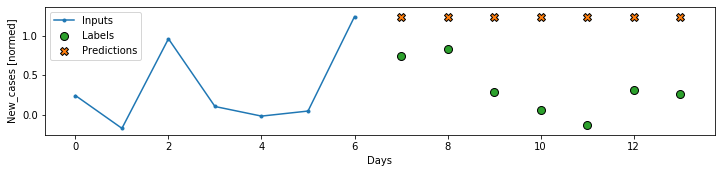

In [74]:
multi_window.plot(last_baseline)

In [75]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [76]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

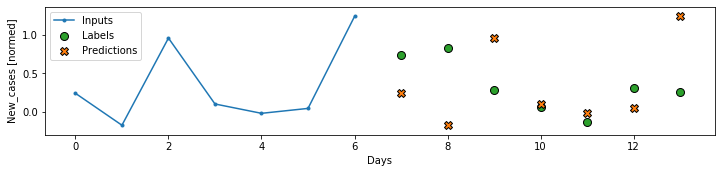

In [77]:
multi_window.plot(repeat_baseline)

### Single shot

In [78]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 53ms/step - loss: 1.0918 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0918 - val_loss: 2.0816 - val_mean_absolute_error: 0.4691 - val_mean_squared_error: 2.0816
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 1.0908 - mean_absolute_error: 0.5736 - mean_squared_error: 1.0908 - val_loss: 2.0813 - val_mean_absolute_error: 0.4693 - val_mean_squared_error: 2.0813
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 1.0898 - mean_absolute_error: 0.5734 - mean_squared_error: 1.0898 - val_loss: 2.0807 - val_mean_absolute_error: 0.4693 - val_mean_squared_error: 2.0807
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0890 - mean_absolute_error: 0.5733 - mean_squared_error: 1.0890 - val_loss: 2.0804 - val_mean_absolute_error: 0.4694 - val_mean_squared_error: 2.0804
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0881 - mean_absolute_error: 0.5732 

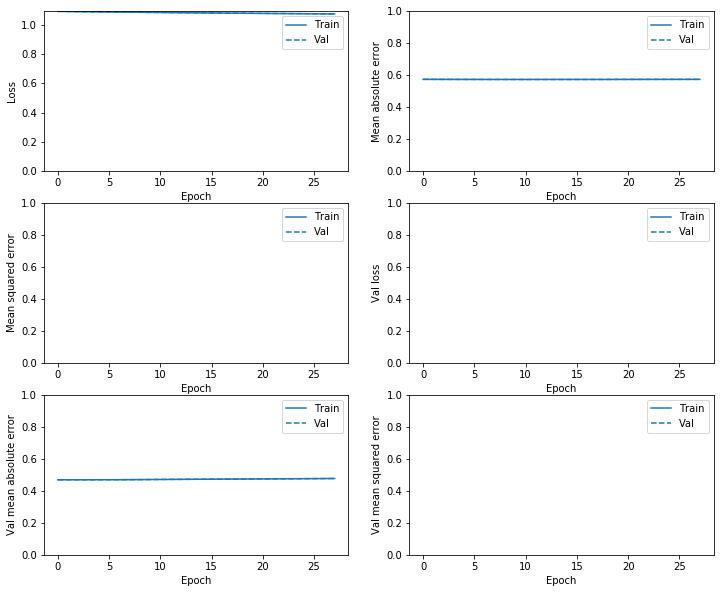

In [79]:
plot_metrics(history)

In [80]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.0774 - mean_absolute_error: 0.4772 - mean_squared_error: 2.0774


In [81]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

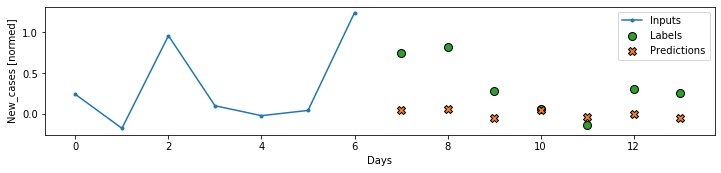

In [82]:
multi_window.plot(multi_linear_model)

In [83]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 53ms/step - loss: 1.0903 - mean_absolute_error: 0.5739 - mean_squared_error: 1.0903 - val_loss: 2.0840 - val_mean_absolute_error: 0.4716 - val_mean_squared_error: 2.0840
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0804 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0804 - val_loss: 2.0861 - val_mean_absolute_error: 0.4760 - val_mean_squared_error: 2.0861
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0703 - mean_absolute_error: 0.5740 - mean_squared_error: 1.0703 - val_loss: 2.0871 - val_mean_absolute_error: 0.4809 - val_mean_squared_error: 2.0871


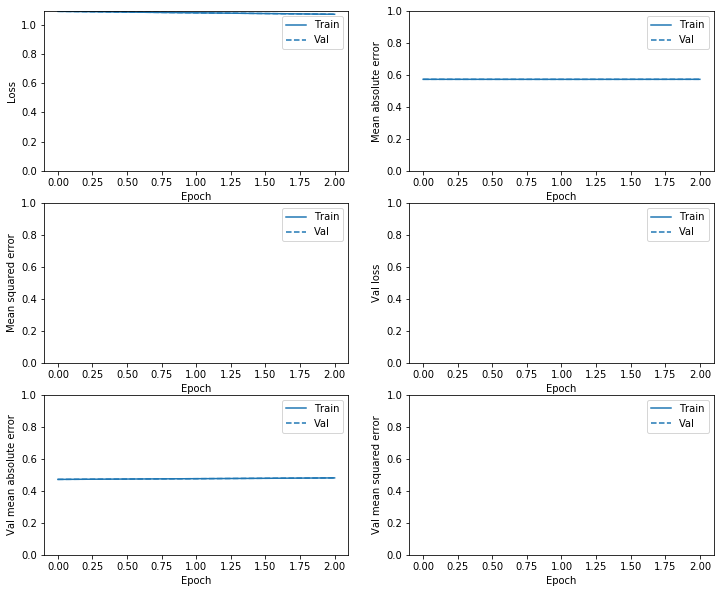

In [84]:
plot_metrics(history)

In [85]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.0871 - mean_absolute_error: 0.4809 - mean_squared_error: 2.0871


In [86]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

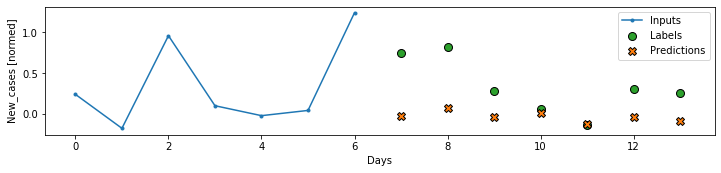

In [87]:
multi_window.plot(multi_dense_model)

In [88]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 135ms/step - loss: 1.0917 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0917 - val_loss: 2.0823 - val_mean_absolute_error: 0.4691 - val_mean_squared_error: 2.0823
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 1.0903 - mean_absolute_error: 0.5737 - mean_squared_error: 1.0903 - val_loss: 2.0823 - val_mean_absolute_error: 0.4693 - val_mean_squared_error: 2.0823
Epoch 3/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0891 - mean_absolute_error: 0.5735 - mean_squared_error: 1.0891 - val_loss: 2.0823 - val_mean_absolute_error: 0.4696 - val_mean_squared_error: 2.0823
Epoch 4/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0876 - mean_absolute_error: 0.5734 - mean_squared_error: 1.0876 - val_loss: 2.0820 - val_mean_absolute_error: 0.4699 - val_mean_squared_error: 2.0820
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0860 - mean_absolute_error: 0.5733

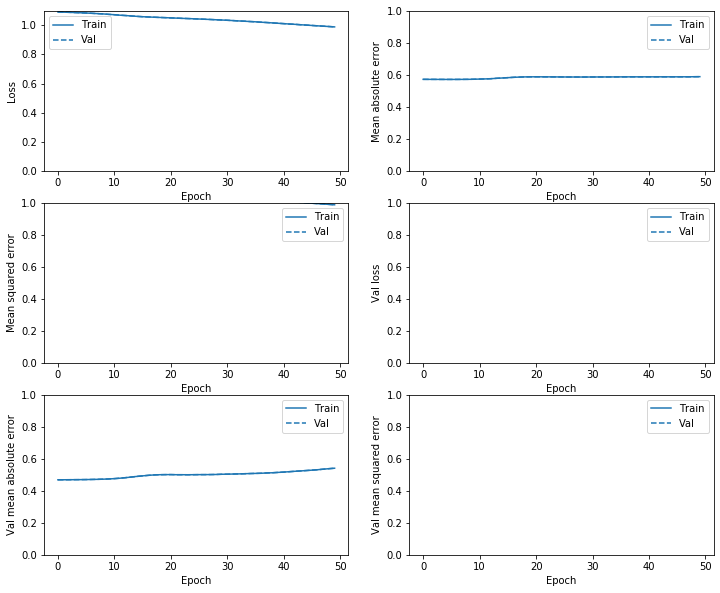

In [89]:
plot_metrics(history)

In [90]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 972us/step - loss: 2.0325 - mean_absolute_error: 0.5415 - mean_squared_error: 2.0325


In [91]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

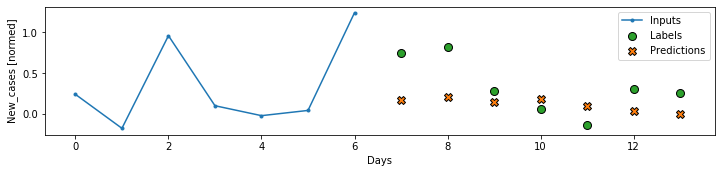

In [92]:
multi_window.plot(multi_lstm_model)

## AR model

In [93]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [94]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [95]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 121ms/step - loss: 1.1189 - mean_absolute_error: 0.5820 - mean_squared_error: 1.1189 - val_loss: 2.0914 - val_mean_absolute_error: 0.4779 - val_mean_squared_error: 2.0914
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 1.1090 - mean_absolute_error: 0.5795 - mean_squared_error: 1.1090 - val_loss: 2.0924 - val_mean_absolute_error: 0.4749 - val_mean_squared_error: 2.0924
Epoch 3/50
3/3 [==============================] - 0s 26ms/step - loss: 1.1006 - mean_absolute_error: 0.5776 - mean_squared_error: 1.1006 - val_loss: 2.0917 - val_mean_absolute_error: 0.4750 - val_mean_squared_error: 2.0917


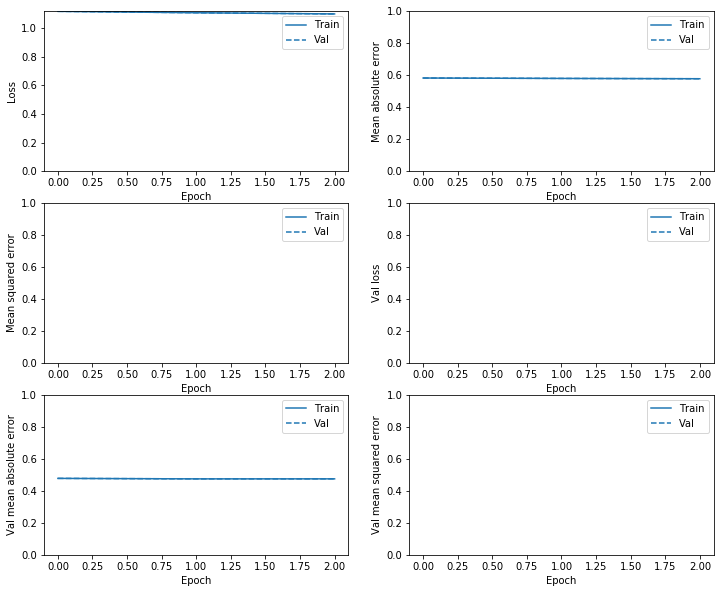

In [96]:
plot_metrics(history)

In [97]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.0917 - mean_absolute_error: 0.4750 - mean_squared_error: 2.0917


In [98]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

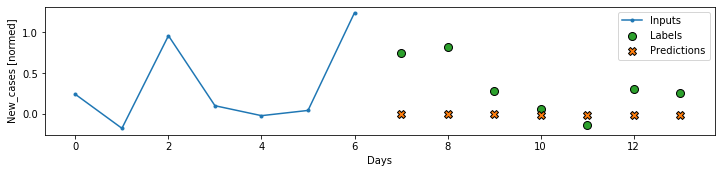

In [99]:
multi_window.plot(feedback_model)

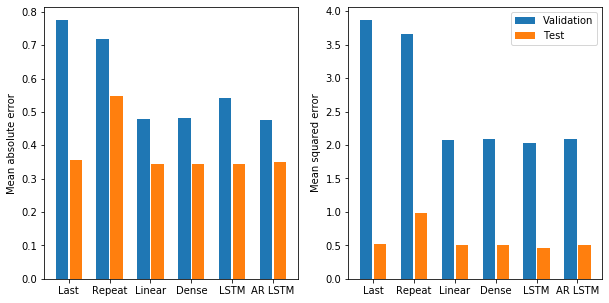

In [100]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)